# Exploratory analysis of model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')#, force_remount=True)
folder_path = '/content/drive/MyDrive/Thesis Johanne/Code'
import sys
sys.path.insert(0, folder_path)

Mounted at /content/drive


In [ ]:
# Install dependencies
!pip uninstall -y torchtext torchdata
!pip install torch==1.11.0+cu115 torchvision==0.12.0+cu115 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu115
!pip install -U openmim
!mim install mmengine
!mim install https://github.com/open-mmlab/mmdetection/archive/refs/tags/v2.28.2.zip

Found existing installation: torchtext 0.15.2
Uninstalling torchtext-0.15.2:
  Successfully uninstalled torchtext-0.15.2
Found existing installation: torchdata 0.6.1
Uninstalling torchdata-0.6.1:
  Successfully uninstalled torchdata-0.6.1
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu115
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 GB 437.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 7.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 

Looking in links: https://download.openmmlab.com/mmcv/dist/cu115/torch1.11.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.5/437.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 10.8 MB/s eta 0:00:00
Looking in links: https://download.openmmlab.com/mmcv/dist/cu115/torch1.11.0/index.html
     / 20.8 MB 22.6 MB/s 0:00:02
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 MB 6.2 MB/s eta 0:00:00
  Created wheel for mmdet: filename=mmdet-2.28.2-py3-none-any.whl size=1494334 sha256=aadcf97039491c13368a23c813c34d8df44ab9ef56a2a5397f9e1ed2433a420d
  Stored in directory: /tmp/pip-ephem-wheel-cache-xvz5mls_/wheels/c3/fe/d6/76390a3734deeeeb6885c4ff3ebc40cea36128e06fd36ac20e
Successfully built mmdet


In [ ]:
from mmdet.apis import show_result_pyplot
from mmdet.apis.inference import LoadImage
from mmdet.core import bbox2roi
from mmdet.core.bbox.transforms import bbox2roi
from mmdet.datasets.pipelines import Compose
from mmcv.parallel import scatter
import torch
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon as Polygon_mpl
import random
from pycocotools.coco import COCO
np.set_printoptions(formatter={'all':lambda x: str(x)})
from mmdet.datasets import build_dataset

In [ ]:
# Set random seed
seed = 3047
set_random_seed(seed, deterministic=False)

In [ ]:
# Initialize the model
config = Config.fromfile(f'{folder_path}/config.py')
checkpoint = f'{folder_path}/model_output_4/model.pth'
model = init_detector(config, checkpoint, device='cuda:0');

In [ ]:
# Get annotations for single image
img_id = img_ids_all[1001]
ann_ids = coco.getAnnIds(imgIds=[img_id])
anns = coco.loadAnns(ann_ids)
bboxes = [ann['bbox'] for ann in anns]
bboxes_formatted = np.array([[bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]] for bbox in bboxes])
bboxes_formatted_sc = np.array([np.append(bbox, 1.) for bbox in bboxes_formatted])

# Load image
filename = coco.loadImgs([img_id])[0]['file_name']
dir = f'{folder_path}/data/images/streetview_2/'
img = mmcv.imread(dir + filename)

In [ ]:
# Preprocess image according to model test pipeline
img_index = [i for i, img in enumerate(datasets[0].data_infos) if img['id'] == img_id][0]
img_info = datasets[0].data_infos[img_index]
ann_info = datasets[0].get_ann_info(img_index)
results = dict(img_info=img_info, ann_info=ann_info)
results['img_prefix'] = f'{folder_path}/data/images/streetview_2'
results['bbox_fields'] = []

pipeline = Compose(model.cfg.data.train.pipeline)
data_orig = pipeline(results)
data = scatter(data_orig, [0])[0] # scatter to specified GPU
img_tensor = data['img']

In [ ]:
# Show information about the image needed by the model so that it can be manually copied to next cell
[data_orig[key] for key in ['img_metas']]

[DataContainer({'filename': '/content/drive/MyDrive/Thesis Johanne/Code/data/images/streetview_2/nfUg9I_P-rZxq-V3N_D49Q.jpg', 'ori_filename': 'nfUg9I_P-rZxq-V3N_D49Q.jpg', 'ori_shape': (832, 1664, 3), 'img_shape': (832, 1664, 3), 'pad_shape': (832, 1664, 3), 'scale_factor': array([1.0, 1.0, 1.0, 1.0], dtype=float32), 'flip': False, 'flip_direction': None, 'img_norm_cfg': {'mean': array([123.675, 116.28, 103.53], dtype=float32), 'std': array([58.395, 57.12, 57.375], dtype=float32), 'to_rgb': True}})]

In [ ]:
# Copy the dict inside the DataContainer and paste it here
flip = False
img_metas = [{'filename': f'/content/drive/MyDrive/Thesis Johanne/Code/data/images/streetview_2/{filename}',
              'ori_filename': filename,
              'ori_shape': (1024, 2048, 3),
              'img_shape': (832, 1664, 3),
              'pad_shape': (832, 1664, 3),
              'flip': flip,
              'flip_direction': 'horizontal' if flip else None,
              'img_norm_cfg': {
                  'mean': np.array([123.675, 116.28 , 103.53 ], dtype=np.float32),
                  'std': np.array([58.395, 57.12 , 57.375], dtype=np.float32),
                  'to_rgb': True}}]
scale_factor = img_metas[0]['img_shape'][0] / img_metas[0]['ori_shape'][0]
img_metas[0]['scale_factor'] = np.array([scale_factor] * 4, dtype=np.float32)

In [ ]:
# Get feature map from Swin Transformer
feature_maps_swin = model.backbone(img_tensor.reshape((1, *img_tensor.shape)))

# Get feature map from FPN
feature_maps_fpn = model.extract_feat(img_tensor.reshape((1, *img_tensor.shape)))

# Get proposals from RPN
proposals_rpn = model.rpn_head.simple_test_rpn(feature_maps_fpn, img_metas)

# Get feature map and proposals from RoI layer
feature_maps_roi = model.roi_head.bbox_roi_extractor(feature_maps_fpn[:model.roi_head.bbox_roi_extractor.num_inputs],
                                                     bbox2roi(proposals_rpn))
proposals_roi = model.roi_head.simple_test(feature_maps_fpn,
                                           proposals_rpn,
                                           img_metas)[0]

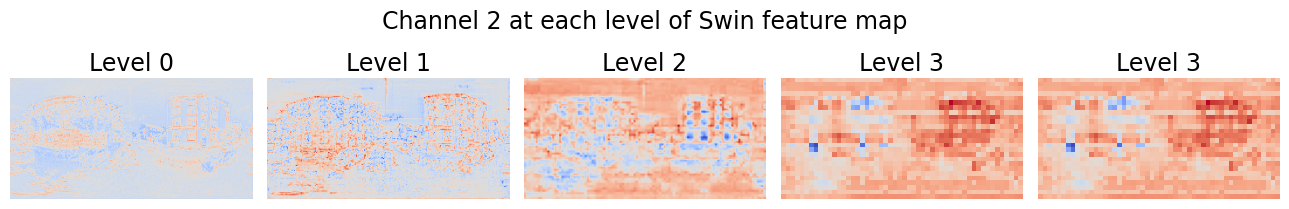

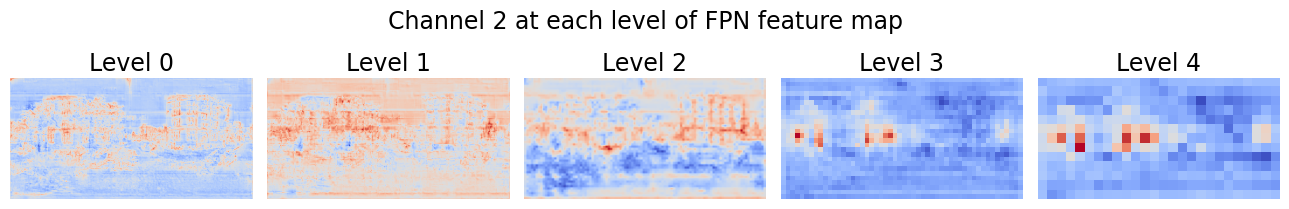

In [ ]:
# Show feature maps
dim = 2
for feature_maps, na in zip([feature_maps_swin, feature_maps_fpn], ['Swin', 'FPN']):
    fig, axs = plt.subplots(1, 5, figsize=(13, 5))
    for level, ax in enumerate(axs):
        if level > (len(feature_maps)-1):
            level -= 1
        feature_map = feature_maps[level][0][dim]
        feature_map_np = feature_map.cpu().detach().numpy()
        ax.imshow(feature_map_np, cmap='coolwarm')
        ax.set_title(f'Level {level}', fontsize=17)
        ax.axis('off')
    plt.suptitle(f'Channel {dim} at each level of {na} feature map', fontsize=17, y=0.72)
    plt.tight_layout()
    plt.savefig(f'{folder_path}/model_output/feature_map_{na.lower()}_c{dim}.png', bbox_inches='tight', pad_inches=0)
    plt.show()

In [ ]:
# Get FPN feature map level for all proposals
rois = bbox2roi(proposals_rpn)
target_lvls = model.roi_head.bbox_roi_extractor.map_roi_levels(rois, num_levels=5)

In [ ]:
# Build RoI layers manually
roi_layers = torch.nn.ModuleList([mmcv.ops.RoIAlign(spatial_scale=1 / s,
                                                    output_size=7,
                                                    pool_mode='max',
                                                    aligned=True) for s in config.model.rpn_head.anchor_generator.strides])

# Get RoI feature map manually
out_size = roi_layers[0].output_size #model.roi_head.bbox_roi_extractor.roi_layers[0].output_size
feature_maps_roi_manual = feature_maps_fpn[0].new_zeros(rois.size(0), model.roi_head.bbox_roi_extractor.out_channels, *out_size)
for level in range(len(feature_maps_fpn)-1):
    inds = (target_lvls == level).nonzero(as_tuple=False).squeeze(1)
    feature_maps_roi_manual[inds] = roi_layers[level](feature_maps_fpn[level], rois[inds])

In [ ]:
# def pool_feature_map(feat_map):
#     window_width, window_height = [int(dim/7) for dim in feat_map.shape]
#     feat_map_pooled = np.zeros((7,7))
#     for i_x in range(7):
#         for i_y in range(7):
#             x1, x2, y1, y2 = window_width*i_x, window_width*(i_x+1), window_height*i_y, window_height*(i_y+1)
#             feat_map_window = feat_map[x1:x2, y1:y2]
#             feat_map_pooled[i_x, i_y] = np.max(feat_map_window)
#     return feat_map_pooled

In [ ]:
def show_anns(bboxes, ax, c):
    # Show bboxes as polygons that can be layered on top of an image
    ax.set_autoscale_on(False)
    polygons = []
    for bbox in bboxes:
        bbox_x1, bbox_y1, bbox_x2, bbox_y2 = bbox[:-1]
        polygon = [[bbox_x1, bbox_y1],
                   [bbox_x1, bbox_y2],
                   [bbox_x2, bbox_y2],
                   [bbox_x2, bbox_y1]]
        polygons.append(Polygon_mpl(np.array(polygon)))
    edges = PatchCollection(polygons, facecolor='none', edgecolors=c, linewidths=1.5)
    ax.add_collection(edges)

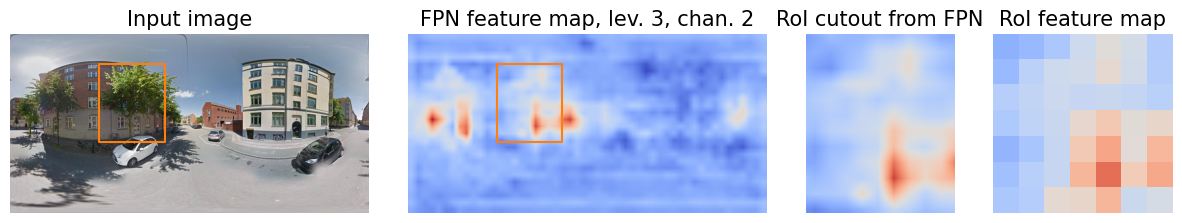

In [ ]:
# Show RoI with highest score
# and one of the corresponding feature maps by FPN and the RoI layer

# Rescale image to size after preprocessing
img_rescaled_1, scale_1 = mmcv.imrescale(img, model.cfg.test_pipeline[1].img_scale, return_scale=True)

# Plot RoI
idx = 1
fig, axs = plt.subplots(1, 4, gridspec_kw={'width_ratios': [2.52, 2.52, 1.04, 1.26]}, figsize=(15, 3))
axs[0].imshow(img_rescaled_1[:,:,::-1])
show_anns(proposals_rpn[0].cpu().detach().numpy()[[idx]], axs[0], c='#ff7f0e')
axs[0].set_title(f'Input image', fontsize=15)
axs[0].axis('off')

# Plot feature map by Swin (after FPN)
roi = [int(x) for x in proposals_rpn[0].cpu().detach().numpy()[idx][:-1]]
y1, x1, y2, x2 = roi.copy()
level = 3#target_lvls[idx]
dim = 2
feature_map_fpn_dim = feature_maps_fpn[level][0][dim]
feature_map_fpn_dim_rescaled = mmcv.imrescale(feature_map_fpn_dim.cpu().detach().numpy(), tuple(img_rescaled_1.shape[:2]))
proposal_color = int(np.max(feature_map_fpn_dim_rescaled))+2
axs[1].imshow(feature_map_fpn_dim_rescaled, cmap='coolwarm')
show_anns(proposals_rpn[0].cpu().detach().numpy()[[idx]], axs[1], c='#ff7f0e')#'#454141')
axs[1].set_title(f'FPN feature map, lev. {level}, chan. {dim}', fontsize=15)
axs[1].axis('off')
vmin, vmax = np.min(feature_map_fpn_dim_rescaled), np.max(feature_map_fpn_dim_rescaled)

# Plot cutout of feature map by Swin
feature_map_fpn_dim_rescaled_cut = feature_map_fpn_dim_rescaled[x1:x2, max(0, y1):y2]
axs[2].imshow(feature_map_fpn_dim_rescaled_cut, cmap='coolwarm', vmin=vmin, vmax=vmax)
axs[2].set_title(f'RoI cutout from FPN', fontsize=15)
axs[2].axis('off')

# Plot feature map by RoI layer
axs[3].imshow(feature_maps_roi_manual[idx][dim].cpu().detach().numpy(), cmap='coolwarm', vmin=vmin, vmax=vmax)
axs[3].set_title(f'RoI feature map', fontsize=15)
axs[3].axis('off')

plt.subplots_adjust(wspace=0.15)
plt.savefig(f'{folder_path}/model_output/feature_map_roi.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
# Get feature maps and proposals for ground truth bounding boxes
proposals_rpn_gt = torch.cat((torch.tensor(np.c_[bboxes_formatted * img_metas[0]['scale_factor'], np.ones(bboxes_formatted.shape[0])]).to(dtype=torch.float32).to(device='cuda:0'),
                              proposals_rpn[-1:][0]), 0)
feature_maps_roi_gt = model.roi_head.bbox_roi_extractor(feature_maps_fpn[:model.roi_head.bbox_roi_extractor.num_inputs],
                                                        bbox2roi([proposals_rpn_gt]))
proposals_roi_gt = model.roi_head.simple_test(feature_maps_fpn,
                                                [proposals_rpn_gt],
                                                img_metas)[0]

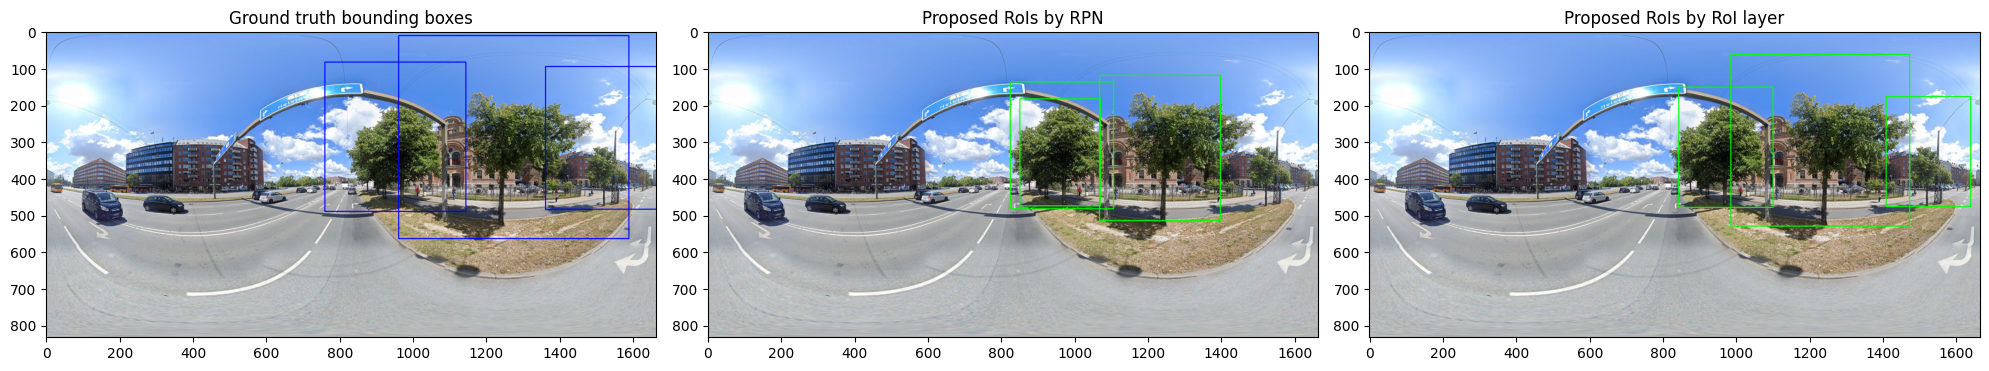

In [ ]:
# Get proposed bounding boxes by the RPN and RoI
# with the highest probability of containing an object

# Plot ground truth bounding boxes for reference
fig, axs = plt.subplots(1, 3, figsize=(20, 20))
output = mmcv.imshow_bboxes(img_rescaled_1.copy()[...,::-1], bboxes_formatted * img_metas[0]['scale_factor'], show=False, thickness=2, colors=['red'])
axs[0].imshow(output)
axs[0].set_title('Ground truth bounding boxes')

# Plot proposed bounding boxes
k = bboxes_formatted.shape[0] # number of proposals
max_score = sorted([bbox[-1] for c in proposals_roi for bbox in c], reverse=True)[k-1]
proposals_roi_top = np.array([bbox for c in proposals_roi for bbox in c if bbox[-1] >= max_score])
for ax, proposals, proposal_type in zip(axs[1:], [proposals_rpn[0].cpu().detach().numpy(), proposals_roi_top], ['RPN', 'RoI layer']):
    output = mmcv.imshow_bboxes(img_rescaled_1.copy()[...,::-1], proposals[:k], show=False, thickness=2)
    ax.imshow(output)
    ax.set_title(f'Proposed RoIs by {proposal_type}')
plt.tight_layout()
plt.show()

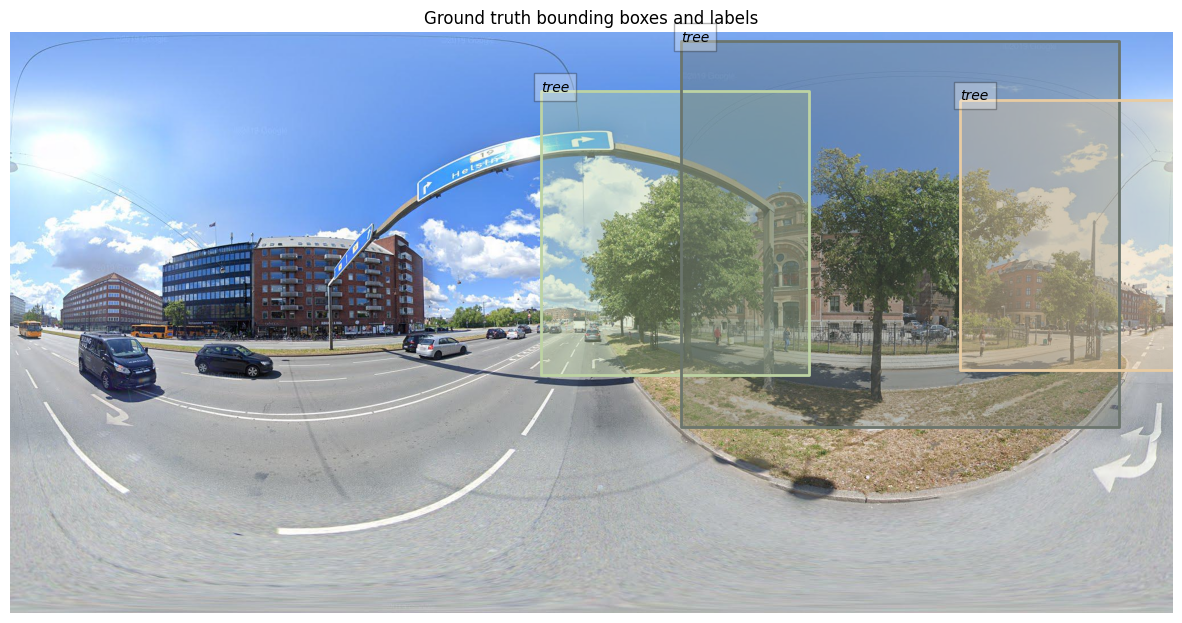

In [ ]:
# Show ground truth bounding boxes and labels
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img[...,::-1])
ax.axis('off')
ax.set_title('Ground truth bounding boxes and labels')
coco.showAnns(anns, draw_bbox=True)
for i, ann in enumerate(anns):
    ax.text(ann['bbox'][0], ann['bbox'][1], coco.loadCats(ann['category_id'])[0]['name'], style='italic',
            bbox={'facecolor': 'white', 'alpha': 0.3, 'pad': 5})
plt.show()

In [ ]:
# # Show (final) predicted bounding boxes by Faster R-CNN
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.8)

### Visualize anchors

In [ ]:
import os
from PIL import Image
import numpy as np
np.set_printoptions(formatter={'all':lambda x: str(x)})
from mmdet.core import AnchorGenerator
import matplotlib.pyplot as plt
from mmcv import Config

In [ ]:
def show_anchors(img, strides, ratios, scales):
    fig, axes = plt.subplots(1, 3, figsize=(30, 30))
    for ratio, ax in zip(ratios, axes):
        # Get all anchors
        self = AnchorGenerator(strides, [ratio], scales)
        anchors_all = self.grid_priors([img.shape[:2]], device='cpu')[0].cpu().detach().numpy()

        # Get single anchor
        img_width = img.shape[0]
        anchors_single = anchors_all[int(img_width*12+8):int(img_width*12+9)]

        # Show anchors
        output = mmcv.imshow_bboxes(img.copy(), anchors_single, show=False, thickness=3)
        ax.axis('off')
        ax.set_title(f'Anchor of stride {strides[0]}, scale {scales[0]}, and ratio {ratio}')
        ax.imshow(output)
    plt.show()

In [ ]:
# Show smallest and largest anchor sizes at each ratio
cfg = Config.fromfile('/content/drive/MyDrive/Thesis Johanne/Code/config.py')
cfg_anchor = cfg.model.rpn_head.anchor_generator
strides = cfg_anchor.strides
ratios = cfg_anchor.ratios
scales = cfg_anchor.scales
for stride in strides:
    for scale in scales:
        show_anchors(img_rescaled_1[...,::-1].copy(), strides=[stride], ratios=ratios, scales=[scale])